<a href="https://colab.research.google.com/github/wakamatsuikuma/MEMO_causal_analysis_by_python/blob/main/6_3_LiNGAM%E3%81%AB%E3%82%88%E3%82%8B%E5%9B%A0%E6%9E%9C%E6%8E%A2%E7%B4%A2%E3%81%AE%E5%AE%9F%E8%A3%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【メモ】  
以下の①線形な構造方程式、 ②独立成分分析をベースとして解く  

以下の4つの適用条件がある  
かなり強い前提があることが窺える  
(参考:http://webmaking.rei-farms.jp/webmaking/python/5878/)  
1. Liner：線形な構造方程式で示せる  
2. Non-Gaussian:構造方程式の誤差項が非ガウス分布である  
3. Acyclic：非循環な因果グラフ(DAG)で表せる
4. 構造方程式：未観測な要因が存在しない

・線形な構造方程式について  
線形な構造方程式であり、誤差項が非ガウス(ガウス分布に従わない)という前提の基で因果探索する。  
観測データ：x  
変数間の係数：B  
誤差項:e_ica  
とした時に、  
ｘ ＝ B * x + e  
となる**Bを求める**。
またAcyclicも前提としているので、Bは対角成分が0かつ下三角行列となる(Bの制限)。  
さらに構造方程式をxについて解くと、 x = ( I - B )_inv * e_ica (Iは単位行列)  
  
・独立成分分析  
変数間の関係を独立にする（データがガウス分布に従っている場合は、相関0=独立。データが非ガウスの場合は、相関0≠独立。）  
独立成分分析を実施することで、  
x = A_ica * x_ica と分解できる。  
これは  x = A_ica * e_ica  と考えることができる。  
したがって、LiNGAMでは  
**"観測したデータxに対して、独立成分分析を実施すること"**  
で構造方程式を求めることができる。  
ただし、Bの制限よりA_ica_invは対角成分1の下三角行列となるように**行の大きさ**と**行の順番**を調整する必要がある。  

・アルゴリズムの概要  
① データxを独立成分分析によりA_ica * e_icaに分解して、A_ica_invを求める  
② A_ica_invの対角成分が1となるように、行の順番の並び替え(理論・実装共に複雑なので理解は後回し)  
並び替えの基準：  
"対角成分が1"  
↓  
"対角成分が非ゼロ"  
↓  
"対角成分の絶対値の最大化"  
↓  
"絶対値行列の逆数行列の対角成分の和の最小化"  
で解く。  
③ A_ica_invの対角成分が1になるように、各行を割り算  
④ Bを求める(対角成分は0なる)  
⑤ Bが下三角行列にするように手続き (変数間のパスがわかる) 
1.  上側成分が0になるはずの数だけ、絶対値が小さい成分を0にする
2.  並び替えて下三角行列になるか確認
3.  ならない場合は、"さらに1つ絶対値の小さい成分を0→並び替えて下三角行列になるか確認"を繰り返す  
  
⑥ 求めたBから判明したパスの数の分だけ回帰モデルを構築して因果の大きさを求める(ゼロ化操作した上での係数を求めたいから！！)




# 設定

In [1]:
# 乱数のシードを固定
import random
import numpy as np

random.seed(1234)
np.random.seed(1234)

In [2]:
# 使用するパッケージ(ライブラリと関数)　を定義
import pandas as pd

# データ生成

## モデル
x1 = 3×x2 + ex1

x2 = ex2

x3 = 2×x1 + 4×x2 + ex3
 

In [3]:
# データ数
num_data = 200

# 非ガウスのノイズ
ex1 = 2.0*(np.random.rand(num_data)-0.5)
ex2 = 2.0*(np.random.rand(num_data) -0.5)
ex3 = 2.0*(np.random.rand(num_data) -0.5)

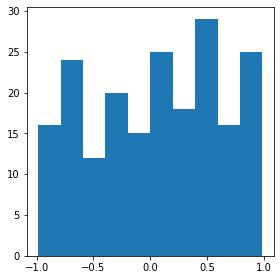

In [4]:
#　ノイズの分布確認→非ガウスを確認
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(1, 1, 1)

ax1.hist(ex1)

plt.tight_layout()

In [9]:
# データ生成
ｘ２ = ex2
x1 = 3*x2 + ex1
x3 = 2*x1 + 4*x2 + ex3

# 表にまとめる
df = pd.DataFrame({"x1":x1, "x2":x2, "x3":x3})
display(df.head())
print(df.shape)

,x1,x2,x3
0,2.257272,0.958078,8.776842
1,2.531611,0.762464,8.561263
2,0.641547,0.255364,1.341902
3,3.153636,0.860973,9.322791
4,1.908691,0.449580,5.776675


(200, 3)


# ①独立成分分析よりA_ica_invを求める

In [12]:
# 独立成分はscikit-learnの関数を使用
from sklearn.decomposition import FastICA

ica = FastICA(random_state=1234).fit(df)

In [13]:
# ICAで求めた行列A
A_ica = ica.mixing_
print("A_icaのshape:", A_ica.shape)

A_icaのshape: (3, 3)


In [14]:
# 行列Aの逆行列を求める
A_ica_inv = np.linalg.pinv(A_ica)
print(A_ica_inv)

[[-0.23203107 -0.4635971   0.1154553 ]
 [-0.02158245  0.12961253  0.00557934]
 [-0.11326384  0.40437635 -0.00563091]]


# ②A_ica_invの対角成分が1となるように、行の順番の並び替え

In [16]:
# 実行するためのパッケージをインストールしてインポート
!pip install munkres
from munkres import Munkres
from copy import deepcopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# 実装の参考
# [5] Qiita：LiNGAMモデルの推定方法について
# https://qiita.com/m__k/items/bd87c063a7496897ba7c

# ①「行の順番を変換」→対角成分の絶対値を最大にする
# （元のA^-1の対角成分は必ず0ではないので）

# 絶対値の逆数にして対角成分の和を最小にする問題に置き換える
A_ica_inv_small = 1 / np.abs(A_ica_inv)

# 対角成分の和を最小にする行の入れ替え順を求める
m = Munkres()  # ハンガリアン法
ixs = np.vstack(m.compute(deepcopy(A_ica_inv_small)))

# 求めた順番で変換
ixs = ixs[np.argsort(ixs[:, 0]), :]
ixs_perm = ixs[:, 1]
A_ica_inv_perm = np.zeros_like(A_ica_inv)
A_ica_inv_perm[ixs_perm] = A_ica_inv
print(A_ica_inv_perm)

# 並び替わった順番
print(ixs)

[[-0.11326384  0.40437635 -0.00563091]
 [-0.02158245  0.12961253  0.00557934]
 [-0.23203107 -0.4635971   0.1154553 ]]
[[0 2]
 [1 1]
 [2 0]]


# ③A_ica_invの対角成分が1になるように、各行を割り算

In [20]:
# 対角成分を取り出す
D = np.diag(A_ica_inv_perm)[:, np.newaxis]
D

array([[-0.11326384],
       [ 0.12961253],
       [ 0.1154553 ]])

In [22]:
# 割り算
A_ica_inv_perm_D = A_ica_inv_perm / D
A_ica_inv_perm_D

array([[ 1.        , -3.57021564,  0.04971498],
       [-0.16651518,  1.        ,  0.0430463 ],
       [-2.00970483, -4.01538182,  1.        ]])

# ④Bを求める(対角成分は0なる)

In [27]:
# B = I - A_ica_inv
B_est = np.eye(len(df.columns)) - A_ica_inv_perm_D
B_est

array([[ 0.        ,  3.57021564, -0.04971498],
       [ 0.16651518,  0.        , -0.0430463 ],
       [ 2.00970483,  4.01538182,  0.        ]])

# ⑤Bが下三角行列にするように手続き(パスがわかる)

In [28]:
# 1. 上側成分が0になるはずの数だけ、絶対値が小さい成分を0にする
# 2. 並び替えて下三角行列になるか確認
# 3. ならない場合は、"さらに1つ絶対値の小さい成分を0→並び替えて下三角行列になるか確認"を繰り返す


# 実装の参考
# [5] Qiita：LiNGAMモデルの推定方法について
# https://qiita.com/m__k/items/bd87c063a7496897ba7c


# 関数を定義
# 2. 並び替えて下三角行列になるか確認
# 3. ならない場合は、"さらに1つ絶対値の小さい成分を0→並び替えて下三角行列になるか確認"を繰り返す
def _slttestperm(b_i):
# b_iの行を並び替えて下三角行列にできるかどうかチェック
    n = b_i.shape[0]
    remnodes = np.arange(n)
    b_rem = deepcopy(b_i)
    p = list() 

    for i in range(n):
        # 成分が全て0である行番号のリスト
        ixs = np.where(np.sum(np.abs(b_rem), axis=1) < 1e-12)[0]

        if len(ixs) == 0:
            return None
        else:
            ix = ixs[0]
            p.append(remnodes[ix])

            #　成分が全て0である行を削除
            remnodes = np.hstack((remnodes[:ix], remnodes[(ix + 1):]))
            ixs = np.hstack((np.arange(ix), np.arange(ix + 1, len(b_rem))))
            b_rem = b_rem[ixs, :]
            b_rem = b_rem[:, ixs]

    return np.array(p)


b = B_est
n = b.shape[0]
assert(b.shape == (n, n))

ixs = np.argsort(np.abs(b).ravel())

for i in range(int(n * (n + 1) / 2) - 1, (n * n) - 1):
    b_i = deepcopy(b)
    b_i.ravel()[ixs[:i]] = 0 # 1. 上側成分が0になるはずの数だけ、絶対値が小さい成分を0にする
    ixs_perm = _slttestperm(b_i)
    if ixs_perm is not None:
        b_opt = deepcopy(b)
        b_opt = b_opt[ixs_perm, :]
        b_opt = b_opt[:, ixs_perm]
        break
b_csl = np.tril(b_opt, -1)
b_csl[ixs_perm, :] = deepcopy(b_csl)
b_csl[:, ixs_perm] = deepcopy(b_csl)

B_est1 = b_csl
print(B_est1)



[[0.         3.57021564 0.        ]
 [0.         0.         0.        ]
 [2.00970483 4.01538182 0.        ]]


# ⑥求めたBから判明したパスの数の分だけ回帰モデルを構築して因果の大きさを求める

In [29]:
# scikit-learnから線形回帰をimport
from sklearn.linear_model import LinearRegression

# 説明変数
X1 = df[["x2"]]
X3 = df[["x1", "x2"]]

# 被説明変数（目的変数）
# df["x1"]
# df["x3"]

# 回帰の実施
reg1 = LinearRegression().fit(X1, df["x1"]) # x2→x1のパスの回帰
reg3 = LinearRegression().fit(X3, df["x3"]) # x1とx2→x3のパスの回帰

# 回帰した結果の係数を出力
print("係数：", reg1.coef_)
print("係数：", reg3.coef_)

係数： [3.14642595]
係数： [1.96164568 4.11256441]
